# Goal

This is just a demonstration of reinforced learning and how it might be applied in drug design. The model by itself has no other practical application.

Molecular Design Optimization (Reinforcement Learning)
Objective: To optimize new drug molecules based on desired properties and efficacy.

Technology: Develop a RL agent that iteratively proposes modifications to molecular structures; e.g., could be guided by predictions from a transformer and GNN, and evaluated by the Perceiver model to maximize the likelihood of clinical success.


In [1]:
%%capture
# !pip install gym
# !pip install gymnasium
# !pip install torch torchvision


In [8]:
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical

import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical
import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem
import random

import bd.log as bdl 
from bd.models import MolecularEnv, Policy

DISCOUNT_FACTOR=0.99
FP_BITS=2048
EPISODES=500
MAX_EPISODE_STEPS=100
LEARNING_RATE=0.01

# Define a simple environment
from rdkit import Chem
from rdkit.Chem import AllChem

def select_action(state, policy):
    ''' Pick an action from the set of possible actions based on the probability vector returned by policy, given state
    '''
    state = state.float()
    probs = policy(state) # xxx sometimes this is all nan, why?
    
    if torch.isnan(probs).any():
        bdl.err("NaNs detected in policy outputs")
        return None  # Add more sophisticated handling here as needed

    #if len(policy.rewards) == 0:
        #bdl.warn(f"+",endl="")
        #bdl.warn(message=f"\nrewards:{policy.rewards}\nstate:{state}\n+probs={probs}")
    m = Categorical(probs)
    action = m.sample()
    policy.saved_log_probs.append(m.log_prob(action))
    return action.item()

def policy_training_step(policy, optimizer):
    reward = 0
    returns = []
    policy_loss = []
    # calculate the discounted reward, emphasizing recent actions
    for r in policy.rewards[::-1]:
        reward = r + DISCOUNT_FACTOR * reward
        returns.insert(0, reward)
    # normalize rewards to be returned
    returns = torch.tensor(returns)
    
    if len(returns) > 1:
        returns = (returns - returns.mean()) / (returns.std() + 1e-5)

    # calculate policy loss
    for log_prob, r in zip(policy.saved_log_probs, returns):
        # use negative log_prob because a higher reward makes a lower loss
        policy_loss.append(-log_prob * r)

    # Backpropagation and parameter updates
    optimizer.zero_grad() # zero out gradient buffers
    policy_loss = torch.cat(policy_loss).sum() # sum the losses across episode steps
    
    # Check if policy_loss is NaN
    if torch.isnan(policy_loss):
        bdl.info("NaN detected in policy_loss, skipping update")
        return
    else:
        bdl.info("Policy updated.")

    policy_loss.backward() # compute gradients
    optimizer.step() # update weights
    
    policy.saved_log_probs.clear()
    policy.rewards.clear()


from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')           
    
# Instantiate the environment and policy
env = MolecularEnv()
policy = Policy(input_size=FP_BITS, output_size=10)  # 2048-bit fingerprint, 10 possible actions
optimizer = optim.Adam(policy.parameters(), lr=LEARNING_RATE)


Average Reward over 45 steps: 0.27


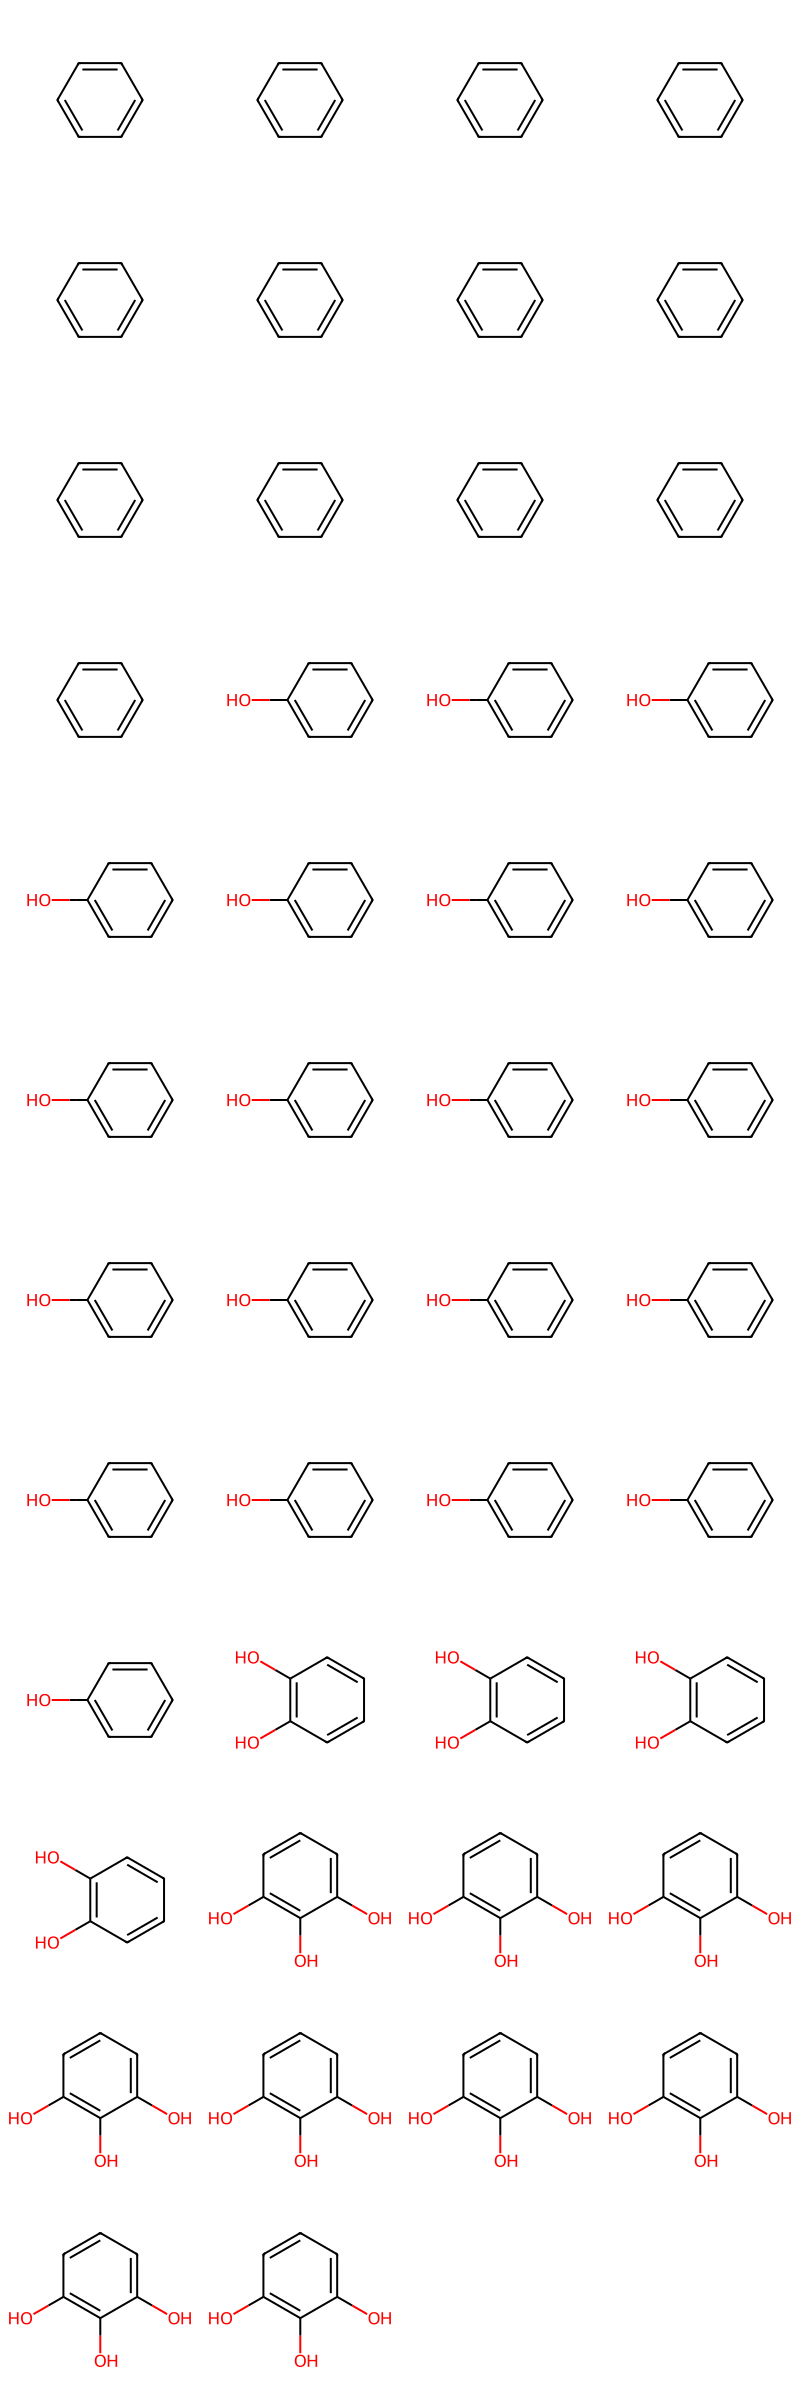

In [10]:
# visualize the agent behavior

from rdkit.Chem import Draw

def visualize_molecule_behavior(env, policy):
    total_rewards = 0
    steps = 0
    state = env.reset()
    mol = Chem.MolFromSmiles('c1ccccc1')  # Assuming starting molecule is a benzene
    mols = [mol]
    while True:
        steps = steps + 1
        state = state.to(dtype=torch.float32).unsqueeze(0)
        action = select_action(state, policy)
        state, reward, done = env.step(action)
        total_rewards += reward.item()
        mol = env.get_current_molecule()
        mols.append(mol)
        if done.item():
            break
    return Draw.MolsToGridImage(mols, molsPerRow=4, subImgSize=(200, 200)), total_rewards, steps
    

# Assuming the environment and policy are already set up
img, rewards, steps = visualize_molecule_behavior(env, policy)

print(f"Average Reward over {steps} steps: {rewards/steps:0.2f}")
display(img)